In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 30)

## Загрузка данных и анализ общей информации

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

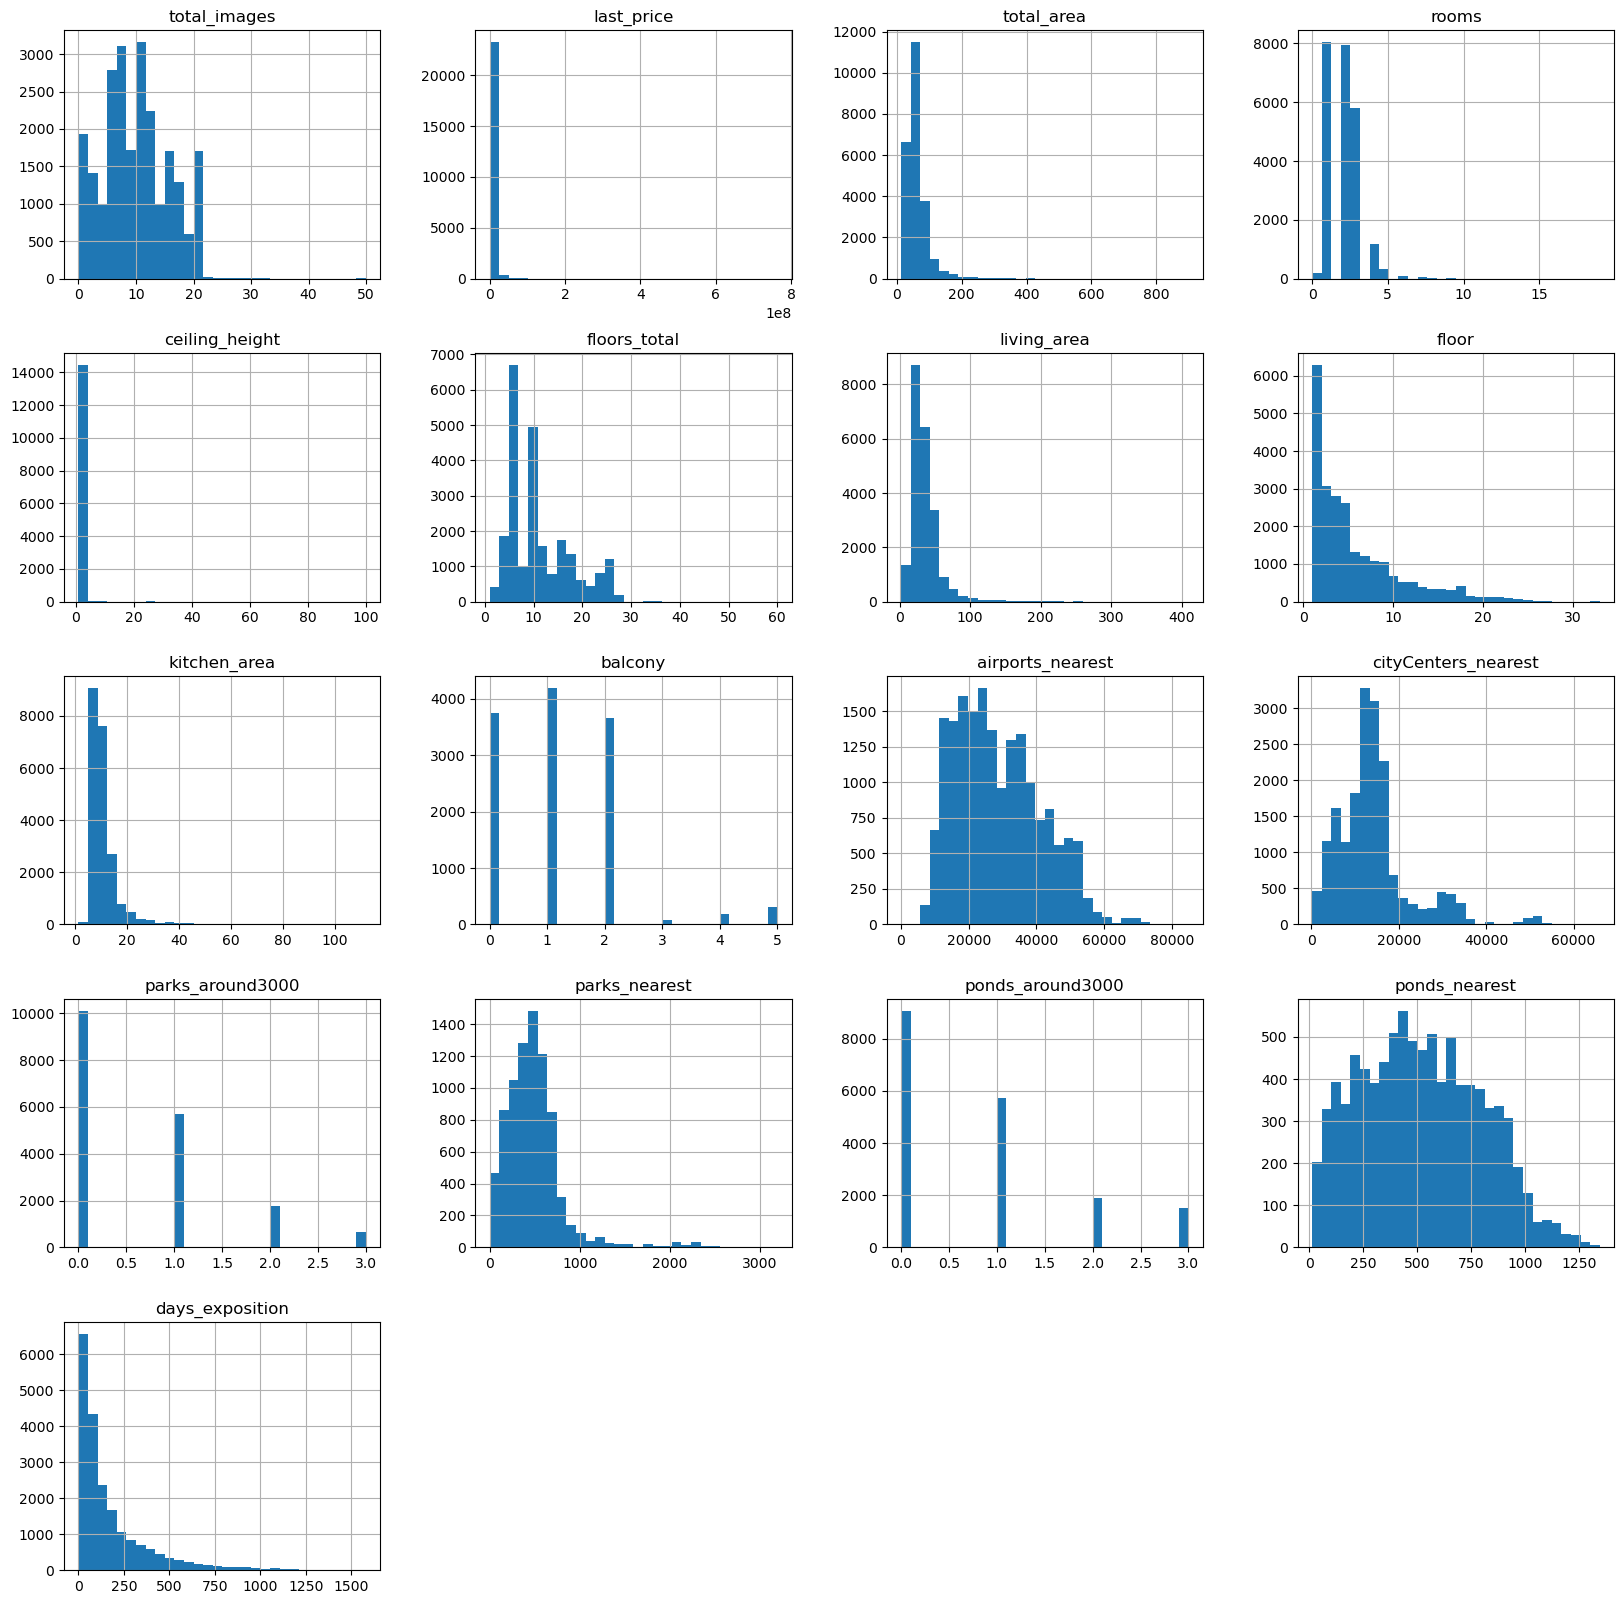

In [5]:
data.hist(figsize=(20, 20), bins=30)
plt.show()

После первоначального анализа данных можно заметить, что для описания недвижимости используется 22 фактора - включая как категориальные, так и числовые переменные. Однако, некоторые из этих факторов содержат пропущенные значения, которые мы будем исправлять в дальнейшем. 

На основе даже первоначальных общих гистограмм (которые содержат пропуски в данных) можно сделать некоторые выводы и о квартирах, и о платформе, на которой были размещены объявления. Так например, в факторе `total_images` виден пик около значения 20, а после наблюдается значительное снижение. Возможно, на платформу нельзя загрузить более 20 фото недвижимости бесплатно. Подробный анализ проведем далее после обработки данных.

## Предобработка данных
### Обработка пропущенных значений

In [6]:
# оценим общее количество пропусков по столбцам
data.isna().sum(axis=0)

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### `ceiling_height` - высота потолков (м)

In [7]:
print(f"Процент пропущенных значений: {data['ceiling_height'].isna().mean():0.2f}")

Процент пропущенных значений: 0.39


In [8]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

В данных представлен достаточно большой процент пропусков. Заменим их медианным значением, группируя по количеству комнат. Выберем этот фактор для группировки, основываясь на том, что высота потолка зависит от площади квартиры, но площаль является непреревной величиной и логичнее использовать именно количетсво комнат, которое, в свою очередь, зависит от площади квартиры. 

Напишем функцию для этой задачи, которая вернет 0, 1, 2, 3, 4 или 5 и более комнат. На основе таких категорий правильнее искать медиану, так как мы скорее всего не попадем в ситуацию, когда есть только одна квартира с n-ым количеством комнат для котой не указана высота потолка (как, например, квартира с 19 комнатами).

In [9]:
def categorize_rooms(rooms):
    try:
        if 0 <= rooms < 5:
            return str(rooms)
        elif rooms >= 5:
            return '5 и более'
        else:
            return 'количество комнат отрицательно'
    except TypeError:
        return 'Неверный тип данных'

In [10]:
# добавим новый столбец для количества комнат
data['rooms_cat'] = data['rooms'].apply(lambda x: categorize_rooms(x))
data.pivot_table(index='rooms_cat', values='ceiling_height', aggfunc=['median', 'count'])

,median,count
,ceiling_height,ceiling_height
rooms_cat,,
0,2.75,82
1,2.64,4613
2,2.60,4850
3,2.65,3789
4,2.80,800
5 и более,3.20,370


Догадка подтвердилась. Значения медиан выглядят адекватно и действительно увеличиваются при увеличении количества комнат.

In [11]:
# произведем замену
for t in data['rooms_cat'].unique():
    data.loc[(data['rooms_cat'] == t) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['rooms_cat'] == t), 'ceiling_height'].median()

In [12]:
data['ceiling_height'].isna().mean()

0.0

Убедились, что пропущенные значения действительно были заменены. В дальнейшем проверим это после всех замен.

#### `floors_total` - всего этажей в доме

In [13]:
print(f"Процент пропущенных значений: {data['floors_total'].isna().mean():0.3f}")
print(f"Медианной количество этажей в доме: {data['floors_total'].median()}")

Процент пропущенных значений: 0.004
Медианной количество этажей в доме: 9.0


Пропущенные значения в факторе общего количетсва этажей в доме составляют <1%, поэтому просто заменит их общей медианой по всему столбцу, которая равняется 9 этажам.

In [14]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

#### `living_area` - жилая площадь в квадратных метрах (м²)

In [15]:
print(f"Процент пропущенных значений: {data['living_area'].isna().mean():0.3f}")

Процент пропущенных значений: 0.080


Относительно большой процент пропусков. Заполним пропуски аналогично фактору `ceiling_height`, но уже на основе общей площади квартиры. И без матрицы корреляции понятно, что чем больше общая площадь, тем больше и жилая.

Напишем функцию для категоризации фактора `total_area`, который представлен в полном виде.

In [16]:
def categorize_total_area(area):
    try:
        if 0 <= area < 40:
            return '<40м'
        elif 40 <= area < 60:
            return '40-60м'
        elif 60 <= area < 80:
            return '60-80м'
        elif 80 <= area < 100:
            return '80-100м'
        elif 100 <= area < 120:
            return '100-120м'
        elif 120 <= area < 140:
            return '120-140м'
        elif area >= 140:
            return '>140м'
        else:
            return 'площадь отрицательная!'
    except TypeError:
        return 'Неверный тип данных'

In [17]:
data['total_area_cat'] = data['total_area'].apply(lambda x: categorize_total_area(x))
data.pivot_table(index='total_area_cat', values='living_area', aggfunc=['median', 'count'])

,median,count
,living_area,living_area
total_area_cat,,
100-120м,63.300,741
120-140м,75.000,354
40-60м,28.705,8336
60-80м,41.600,4585
80-100м,51.200,1856
<40м,17.100,5299
>140м,104.000,625


In [18]:
# произведем замену
for t in data['total_area_cat'].unique():
    data.loc[(data['total_area_cat'] == t) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['total_area_cat'] == t), 'living_area'].median()

#### `is_apartment` - апартаменты (булев тип)

In [19]:
print(f"Процент пропущенных значений: {data['is_apartment'].isna().mean():0.3f}")

Процент пропущенных значений: 0.883


Наблюдаем наибольший процент пропущенных значений, однако восстановить его достаточно легко, если понять, что продавцы квартир, скорее всего, не заполняли данную категорию ввиду того, что у них тип жилье - не апартаменты. Заполним все пропуски нулями.

In [20]:
data['is_apartment'] = data['is_apartment'].fillna(0)

#### `kitchen_area` - площадь кухни в квадратных метрах (м²)

In [21]:
print(f"Процент пропущенных значений: {data['kitchen_area'].isna().mean():0.3f}")

Процент пропущенных значений: 0.096


Аналогично тому, как исправляли фактор жилой площади - исправим и площадь кухни, ведь площадь кухни тоже зависит от общей площади квартиры.

In [22]:
# произведем замену
for t in data['total_area_cat'].unique():
    data.loc[(data['total_area_cat'] == t) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['total_area_cat'] == t), 'kitchen_area'].median()

#### `balcony` - число балконов

In [23]:
print(f"Процент пропущенных значений: {data['balcony'].isna().mean():0.3f}")

Процент пропущенных значений: 0.486


Как и в факторе `is_apartment` продавцы, скорее всего, не указывали ничего в графе `balcony`, если у нет нет ни одного балкона. Заменим все пропуски нулями.

In [24]:
data['balcony'] = data['balcony'].fillna(0)

#### `locality_name` - название населённого пункта

In [25]:
print(f"Процент пропущенных значений: {data['locality_name'].isna().mean():0.3f}")

Процент пропущенных значений: 0.002


Слишком маленький процент пропущенных значений. В данном случае просто удалим эти строки.

In [26]:
data = data.dropna(subset=['locality_name'])

#### Факторы расстояния
`airports_nearest` - расстояние до ближайшего аэропорта в метрах (м)

`cityCenters_nearest` - расстояние до центра города (м)

`parks_around3000` - число парков в радиусе 3 км

`parks_nearest` - расстояние до ближайшего парка (м)

`ponds_around3000` - число водоёмов в радиусе 3 км

`ponds_nearest` - расстояние до ближайшего водоёма (м)

In [27]:
dist_factors = ['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
                'ponds_around3000', 'ponds_nearest']

print('Процент пропущенных значений показателя: ')
for factor in dist_factors:
    print(f" {factor}: {data[factor].isna().mean():0.3f}")

Процент пропущенных значений показателя: 
 airports_nearest: 0.234
 cityCenters_nearest: 0.233
 parks_around3000: 0.233
 parks_nearest: 0.659
 ponds_around3000: 0.233
 ponds_nearest: 0.616


Данные факторы объединяются в одну группу, так как значения в них зависят только от адреса, по которому располагается квартира. Логика заполнения пропущенных значений в них будет одинаковая: заполним медианой на основе названия населенного пункта. Ведь именно зная населенный пункт можно ответить на вопрос: долго ли ехать до аэропорта? или сколько парков в данном районе?

In [28]:
for factor in dist_factors:
    for t in data['locality_name'].unique():
        data.loc[(data['locality_name'] == t) & (data[factor].isna()), factor] = \
        data.loc[(data['locality_name'] == t), factor].median()

In [29]:
print('Процент пропущенных значений показателя: ')
for factor in dist_factors:
    print(f" {factor}: {data[factor].isna().mean():0.3f}")

Процент пропущенных значений показателя: 
 airports_nearest: 0.228
 cityCenters_nearest: 0.228
 parks_around3000: 0.228
 parks_nearest: 0.254
 ponds_around3000: 0.228
 ponds_nearest: 0.232


На данный момент процент пропусков колеблется от 22.8% до 25.4%. **Продолжим эту часть после того, как скорректируем названия населенных пунктов (п. 2.3)**

#### `days_exposition` - сколько дней было размещено объявление (от публикации до снятия)

In [30]:
print(f"Процент пропущенных значений: {data['days_exposition'].isna().mean():0.3f}")

Процент пропущенных значений: 0.134


Пропущенные значения в данном факторе, вероятно, соответствуют объявлениям, которые еще не сняли с сайта (возможно они были только добавлены в день, когда была произведена выгрузка статистики). Можно предположить, что квартиры с определенным метражом в определенных районах продаются за примерно одинаковый срок и заполнить медианой с соответствующей группировкой, однако оставим данный показатель пустым, чтобы можно было анализировать только те квартиры, которые сняли с сайта.

In [31]:
data.isna().sum(axis=0)

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        5386
cityCenters_nearest     5386
parks_around3000        5386
parks_nearest           5998
ponds_around3000        5386
ponds_nearest           5494
days_exposition         3180
rooms_cat                  0
total_area_cat             0
dtype: int64

В ходе данного этапа обработки данных были скорректированы пропущенные значения в данных недвижимости. Во всех показателях, которые имеют прямое отношение к квартирам, такие как: общая площадь, количество комнат, этаж и т.д. - пропуски были заполнены абсолютно везде. Второстепенные же факторы были специально оставлены с пропусками, так как использую данный датасет нельзя достоверно восстановить эту информацию. К второстепенным факторам относятся: количество водоемов вокруг жилья, расстояние до аэропорта, количество парков рядом с домом и другие.

### Корректировка типов данных

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Необходимо скорректировать следующие факторы:
1. first_day_exposition (object -> datetime)
2. is_apartment (object -> bool)

In [33]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['is_apartment'] = data['is_apartment'].astype('bool')

### Удаление дубликатов

In [34]:
data.duplicated().sum()

0

Явных дубликатов не обнаружено. Посмотрим что там с неявными дубликатами. В нашем датасете найти неявные дубликаты можно в колонке `locality_name`.

In [35]:
data['locality_name'].value_counts()

Санкт-Петербург                    15721
посёлок Мурино                       522
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: locality_name, Length: 364, dtype: int64

Всего 364 "уникальных" значения, однако даже на первый взгляд видно, что "поселок" пишется по-разному (где-то с буквой "ё", а где-то с буквой "е". Попробуем вообще убрать это слово и оценим как изменилась картина.

In [36]:
def correct_locality_name(localicy_name):
    change_list = ['поселок ', 'городского типа ',
                   'деревня ', 'садовое товарищество ', 'городской ',
                   'станции ', 'село ', 'садоводческое некоммерческое товарищество ',
                   'при железнодорожной ']
    
    localicy_name = localicy_name.replace('ё','е').lower()
    
    for word in change_list:
        localicy_name = localicy_name.replace(word, '')

    localicy_name = localicy_name.title()
    return localicy_name

In [37]:
data['locality_name_correct'] = data['locality_name'].apply(lambda x: correct_locality_name(x))

In [38]:
data['locality_name_correct'].value_counts()

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
                   ...  
Ропша                  1
Алексеевка             1
Белоостров             1
Пельгора               1
Дзержинского           1
Name: locality_name_correct, Length: 306, dtype: int64

Таким образом, получилось скорректировать 58 неявных дублирующих названий.

**Факторы расстояния (продолжение)**
(п 2.1.8)

In [39]:
for factor in dist_factors:
    for t in data['locality_name_correct'].unique():
        data.loc[(data['locality_name_correct'] == t) & (data[factor].isna()), factor] = \
        data.loc[(data['locality_name_correct'] == t), factor].median()

In [40]:
print('Процент пропущенных значений показателя: ')
for factor in dist_factors:
    print(f" {factor}: {data[factor].isna().mean():0.3f}")

Процент пропущенных значений показателя: 
 airports_nearest: 0.204
 cityCenters_nearest: 0.204
 parks_around3000: 0.204
 parks_nearest: 0.254
 ponds_around3000: 0.204
 ponds_nearest: 0.209


Все-таки осталось около 20% квартир, в которых используя только данный датесет нельзя определить факторы расстояний, поэтому сохраним их пустыми.

### Удаление выбросов и корректировка аномальных значений

In [41]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23650.000000,2.365000e+04,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,18821.000000,18821.000000,18821.000000,17652.000000,18821.000000,18712.000000,20470.000000
mean,9.862326,6.541127e+06,60.329069,2.070106,2.722748,10.669852,34.567366,5.893277,10.469922,0.591712,29545.417991,14465.349291,0.589554,475.966321,0.807768,498.234983,180.753200
std,5.682278,1.089640e+07,35.661808,1.078620,0.990724,6.583725,21.843249,4.883317,5.685816,0.959662,13070.080660,8595.231732,0.795655,235.650384,0.946005,207.448788,219.777916
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.700000,2.000000,7.300000,0.000000,18814.000000,9496.000000,0.000000,428.500000,0.000000,441.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.640000,9.000000,30.000000,4.000000,9.000000,0.000000,27223.000000,13270.000000,0.000000,460.000000,1.000000,503.000000,95.000000
75%,14.000000,6.799000e+06,69.700000,3.000000,2.700000,16.000000,42.000000,8.000000,11.800000,1.000000,38786.000000,16769.000000,1.000000,460.000000,1.000000,552.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


#### `ceiling_height` - высота потолков (м)

In [42]:
data['ceiling_height'].describe()

count    23650.000000
mean         2.722748
std          0.990724
min          1.000000
25%          2.600000
50%          2.640000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

Видим, что встречается максимальная высота потолка равная 100м, вполне возможно, что был пропущен разделитель и высота потолка должна быть 10м. Такая большая высота потолка кажется странной, но возможно она соответствует двухуровневой квартире, поэтомому разделим значение на 10, если оно больше 9 метров.

In [43]:
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x/10 if x>=10 else x)

По остальным данным нельзя с уверенность сказать, что в них есть выбросы, так как и квартиры (или дома) с площадью 900 м² существуют, и стоить они могут очень дорого, и количество комнат в них может равняться даже 19. Поэтому оставим остальные данные без изменений.

## Feature engineering 

В данном блоке сгенерируем новые признаки на основе имеющихся. Такое мы делали ранее, когда заполняли пропущенные значения. Данные признаки могут быть полезны при исследовательском анализе данных. Приступим!

In [44]:
def floor_type(current_floor, floors_total):
    try:
        if current_floor == floors_total:
            return 'последний'
        elif current_floor == 1:
            return 'первый'
        else:
            return 'другой'
    except:
        return 'не удалось определить этаж'

In [45]:
# цена за один квадратный метр в тысячах рублей
data['thousand_rub_per_metr'] = data['last_price']/data['total_area']/1000

# день недели публикации объявления
data['day_exposition'] = data['first_day_exposition'].dt.day

# месяц публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

# год публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year

# тип этажа квартиры
data['floor_type'] = data.apply(lambda row: floor_type(row['floor'],row['floors_total']), axis=1)

# расстояние до центра города в километрах (тип данных оставим float, так как сохранили nan'ы)
data['center_km'] = np.round(data['cityCenters_nearest']/1000,0)

# цена за один квадратный метр
data['last_price_mln'] = data['last_price']/1000000

Посмотрим какие выводы нам помогут сделать созданные факторы в следующем разделе.

## Исследовательский анализ данных
### Анализ численных факторов

Изучим следующие факторы:
* общая площадь;
* жилая площадь;
* площадь кухни;
* цена объекта;
* количество комнат;
* высота потолков;
* этаж квартиры;
* тип этажа квартиры («первый», «последний», «другой»);
* общее количество этажей в доме;
* расстояние до центра города в метрах;
* расстояние до ближайшего аэропорта;
* расстояние до ближайшего парка;
* день и месяц публикации объявления.

#### `total_area` - общая площадь

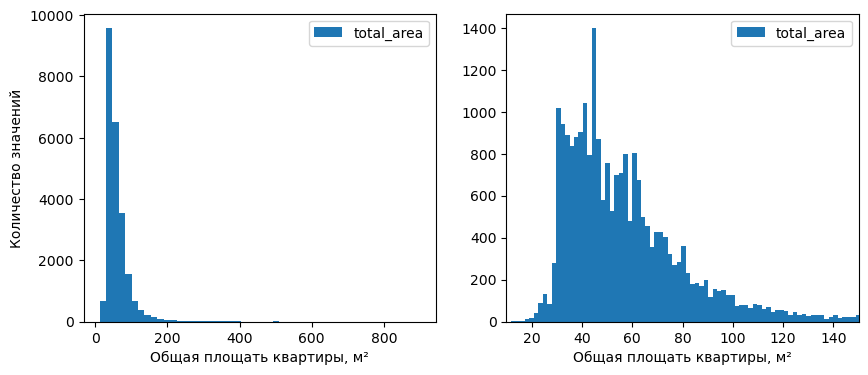

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
data.plot(kind='hist', y='total_area', bins=50, ax=axes[0])
data.plot(kind='hist', y='total_area', bins=500, ax=axes[1], xlim=(10, 150))

axes[0].set_ylabel('Количество значений')
axes[1].set_ylabel('')

axes[0].set_xlabel('Общая площать квартиры, м²')
axes[1].set_xlabel('Общая площать квартиры, м²')

plt.show()

На гистограмма распределения общей площади квартиры видно, что данные имеют распределение Пуассона. Большинство квартир находится в диапазоне от 30 до 100 м². На второй гистограммы представлен данный диапазон более наглядно.

#### `living_area` - жилая площадь в квадратных метрах (м²)

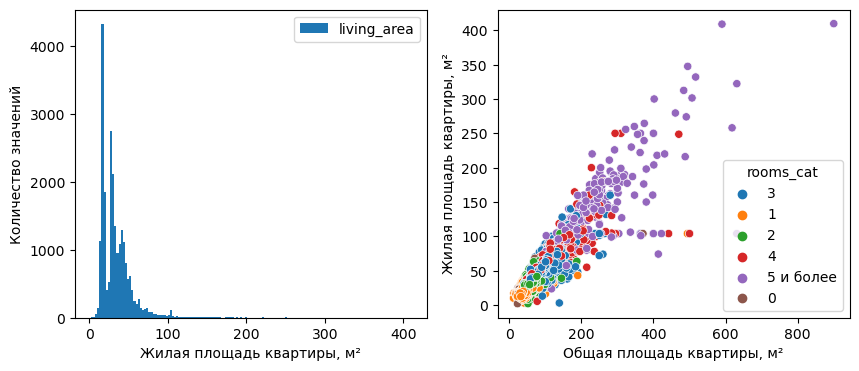

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
data.plot(kind='hist', y='living_area', bins=150, ax=axes[0])
sns.scatterplot(data, y='living_area', x='total_area', hue='rooms_cat')

axes[0].set_ylabel('Количество значений')
axes[1].set_ylabel('Жилая площадь квартиры, м²')

axes[0].set_xlabel('Жилая площадь квартиры, м²')
axes[1].set_xlabel('Общая площадь квартиры, м²')

plt.show()

Наибольшее количество значений жилой площади находится в диапазоне от 10 до 60 м², однако вцелом жилая площадь распределена от 0 до 400 м². Наблюдаем провал значений в районе 22-24 м², возможно это не укладывается в какие-то стандарты? 

Распределение значений жилой площади похоже на распределение общей площади квартиры, что логично. На второй гистограмме наблюдаем высокую прямую корреляцию.

#### `kitchen_area` - площадь кухни в квадратных метрах (м²)

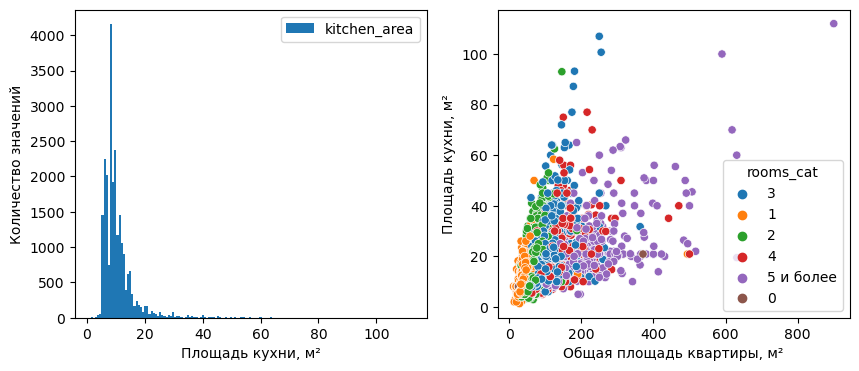

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
data.plot(kind='hist', y='kitchen_area', bins=150, ax=axes[0])
sns.scatterplot(data, y='kitchen_area', x='total_area', hue='rooms_cat')

axes[0].set_ylabel('Количество значений')
axes[1].set_ylabel('Площадь кухни, м²')

axes[0].set_xlabel('Площадь кухни, м²')
axes[1].set_xlabel('Общая площадь квартиры, м²')

plt.show()

Видим примерно ту же тенденцию распространения данных по площади кухни, однако нет такой сильной связи между площадью кухни и общей площадью квартиры, как это было с жилой площадью.

#### `last_price` - цена на момент снятия с публикации

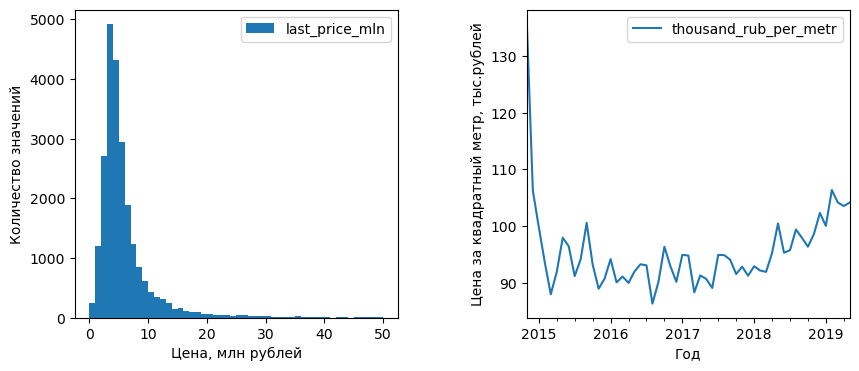

In [49]:
data['date_month'] = data['first_day_exposition'].astype("datetime64[M]")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
data.query('last_price_mln < 50').plot(kind='hist', y='last_price_mln', bins=50, ax=axes[0])
data.pivot_table(index='date_month', values='thousand_rub_per_metr',
                                              aggfunc='median').plot(ax=axes[1])

axes[0].set_ylabel('Количество значений')
axes[1].set_ylabel('Цена за квадратный метр, тыс.рублей')

axes[0].set_xlabel('Цена, млн рублей')
axes[1].set_xlabel('Год')

plt.subplots_adjust(wspace=0.4)
plt.show()

На гистограмме распределения стоимости видно, что большинство квартир в Питере продавались по цене <15млн рублей, однако медианная цена за квадратный метр с 2017 года стала расти. Тем самым на одну и ту же сумму можно купить квартиру меньше с течением времени. Инфляция...

#### `rooms` - число комнат

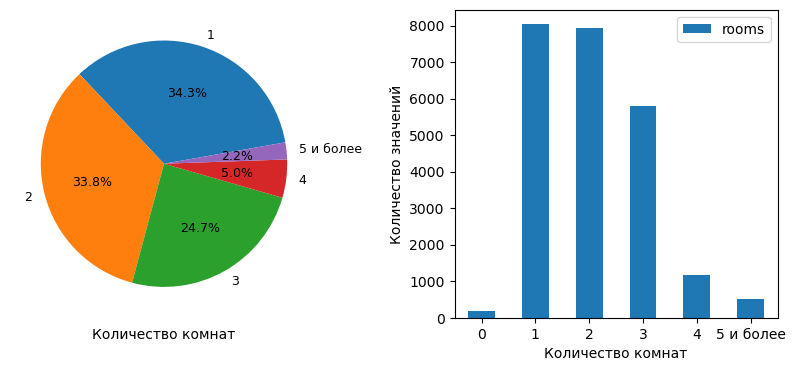

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

data.query("rooms_cat!='0'").pivot_table(index='rooms_cat',
                                         values='rooms',
                                         aggfunc='count').plot(kind='pie',
                                                               y='rooms',
                                                               legend=False,
                                                               ax=axes[0],
                                                               autopct='%1.1f%%',
                                                               startangle=10,
                                                               fontsize=9)

data.pivot_table(index='rooms_cat',values='rooms', aggfunc='count').plot(kind='bar',
                                                                         ax=axes[1], rot=0)
axes[0].set_xlabel('Количество комнат')
axes[0].set_ylabel('')

axes[1].set_xlabel('Количество комнат')
axes[1].set_ylabel('Количество значений')

plt.subplots_adjust(wspace=0.4)
plt.show()

В объявлениях в основном представлены квартиры с 1, 2 и 3 комнатами. В процентном отношении они составляют 91.8% от общего числа объявлений. Квартиры с 4 и более комнатами составляют соответственно 8.2% и это кажется логичным, так как семьям редко нужны квартиры с таким большим пространством. Отметим также квартиры с 0 комнат, вероятно это слишком маленькие помещения, в которых продавец даже не выделяет комнату.

#### `ceiling_height` - высота потолков (м)

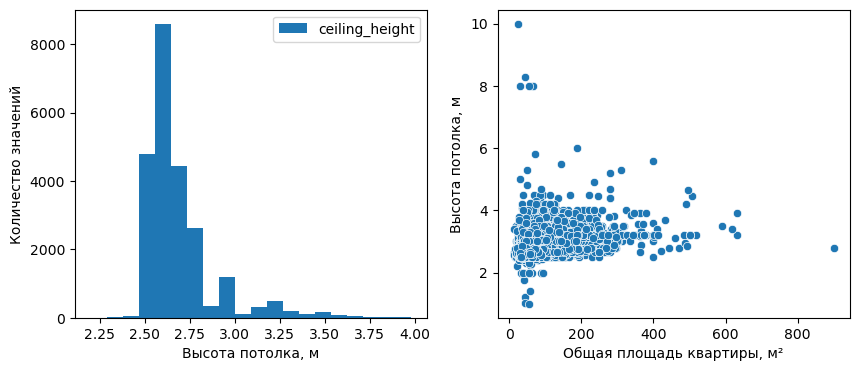

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
data.query('2<ceiling_height<4').plot(kind='hist', y='ceiling_height', bins=20, ax=axes[0])
sns.scatterplot(data, y='ceiling_height', x='total_area')

axes[0].set_ylabel('Количество значений')
axes[1].set_ylabel('Высота потолка, м')

axes[0].set_xlabel('Высота потолка, м')
axes[1].set_xlabel('Общая площадь квартиры, м²')

plt.show()

Наибольшее количество значений высоты потолка соосредоточено от 2.5 до 2.75 метров. Выглядит адекватно. Встречаются значения и больше 3 метров, но не стоит их отбрасывать, так как они могут соответствовать частным домам.

#### `floor` - этаж 

`floor_type` - тип этажа

`floor_total` - всего этажей

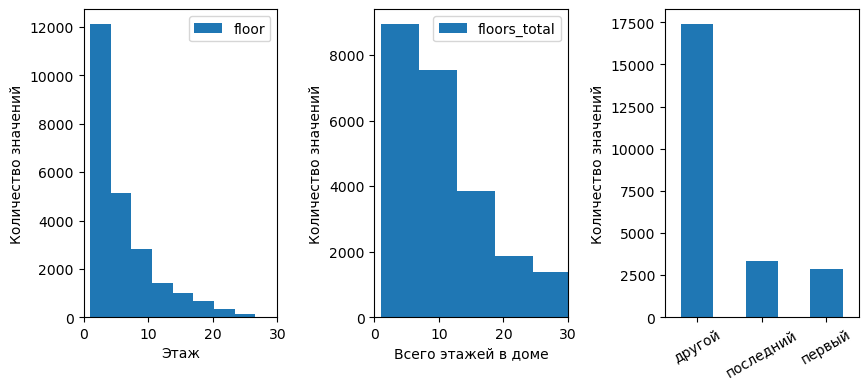

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
data.plot(kind='hist', y='floor', ax=axes[0])
data.plot(kind='hist', y='floors_total', ax=axes[1])
data['floor_type'].value_counts().plot(kind='bar', ax=axes[2], rot=30)

axes[0].set_ylabel('Количество значений')
axes[1].set_ylabel('Количество значений')
axes[2].set_ylabel('Количество значений')

axes[0].set_xlabel('Этаж')
axes[1].set_xlabel('Всего этажей в доме')

axes[0].set_xlim(0, 30)
axes[1].set_xlim(0, 30)

plt.subplots_adjust(wspace=0.5)
plt.show()

Распределение данных этажей, на которых располагаются квартиры примерно соответствует распределению максимальных этажей в домах. Можно сделать вывод, что наибольшее количество домов в Питере высотой 5-10 этажей. Также можно оценить, что объявлений квартир на последнем этаже немного больше, чем квартир с первого этажа.

#### `center_km` - расстояние до центра города в километрах

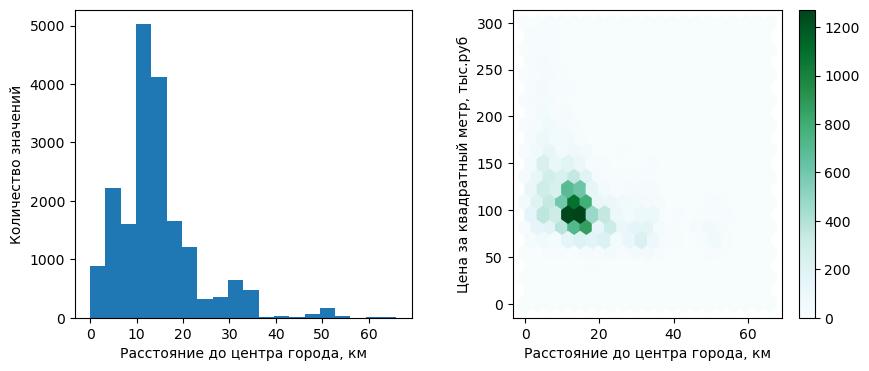

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
data.plot(kind='hist', y='center_km', bins=20, ax=axes[0], legend=False)
data.query('thousand_rub_per_metr<300').plot(kind='hexbin', y='thousand_rub_per_metr', x='center_km', ax=axes[1], gridsize=20)

axes[0].set_ylabel('Количество значений')
axes[1].set_ylabel('Цена за квадратный метр, тыс.руб')

axes[0].set_xlabel('Расстояние до центра города, км')
axes[1].set_xlabel('Расстояние до центра города, км')

plt.subplots_adjust(wspace=0.3)
plt.show()

По данным графикам можно сделать вывод, что большинство квартир находятся в радиусе 20 км от центра. Виден достаточно большой разброс в цене за квадратный метр у объектов, которые находятся в центре, значит в центре не только квартиры, которые стоят одинаково дорого.

#### `airports_nearest` - расстояние до ближайшего аэропорта

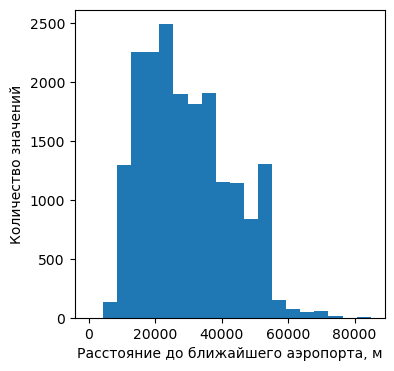

In [54]:
data.plot(kind='hist', y='airports_nearest', bins=20, legend=False, figsize=(4, 4))
plt.ylabel('Количество значений')
plt.xlabel('Расстояние до ближайшего аэропорта, м')

plt.show()

В целом расстояния от аэропорта до объектов недвижимости распределено нормально. Вероятно, не так много домов строят в непосредственной близости от аэропорта и основной объем объектов продажи находится на расстоянии от 10-15 км от аэропорта и дальше.

#### `parks_nearest` - расстояние до ближайшего парка

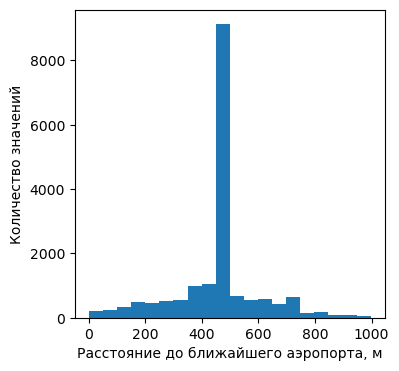

In [55]:
data.query('parks_nearest<1000').plot(kind='hist', y='parks_nearest', bins=20, legend=False, figsize=(4, 4))
plt.ylabel('Количество значений')
plt.xlabel('Расстояние до ближайшего аэропорта, м')

plt.show()

Наблюдаем пик значений около значения 500 метров. Маловероятно, что на самом деле это реальная цифра. Скорее всего, люди знают, что парк находится достаточно близко от дома, но не могут указать точное количество метров, поэтому указывают такое примерное значение, как 500 метров.

#### `day_exposition` и `month_exposition` - день и месяц публикации объявления

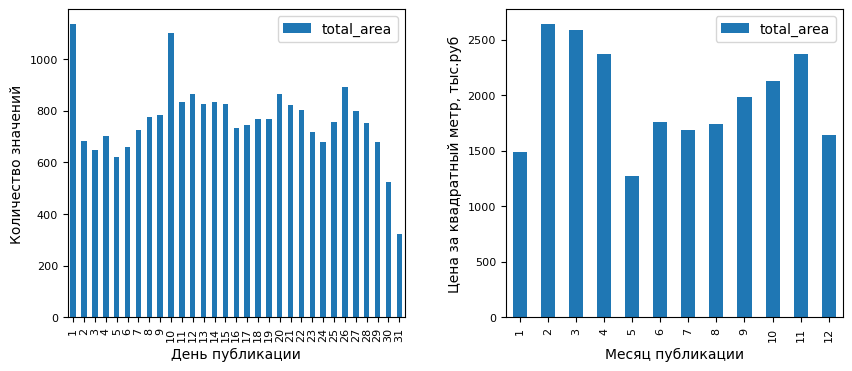

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
data.pivot_table(index='day_exposition', values='total_area', aggfunc='count').plot(kind='bar',
                                                                                    ax=axes[0],
                                                                                    fontsize=8,
                                                                                    rot=90)
data.pivot_table(index='month_exposition', values='total_area', aggfunc='count').plot(kind='bar',
                                                                                    ax=axes[1],
                                                                                    fontsize=8,
                                                                                    rot=90)
axes[0].set_ylabel('Количество значений')
axes[1].set_ylabel('Цена за квадратный метр, тыс.руб')

axes[0].set_xlabel('День публикации')
axes[1].set_xlabel('Месяц публикации')

plt.subplots_adjust(wspace=0.3)
plt.show()

Можем оценить, что наиболее популярные дни для публикации объявления - это 1 и 10 дни месяца, возможно люди планируют такую задачу заранее и легче ее запланировать на круглую дату, или же начало месяца.

Наименее популярные месяцы публикации: январь, май и декабрь. В мае и январе наибольшее количество праздничных дней, а в декабре все готовятся к Новому году. Вместо важных задач люди выбирают отдых - правильный выбор!

#### `days_exposition` - сколько дней было размещено объявление (от публикации до снятия)

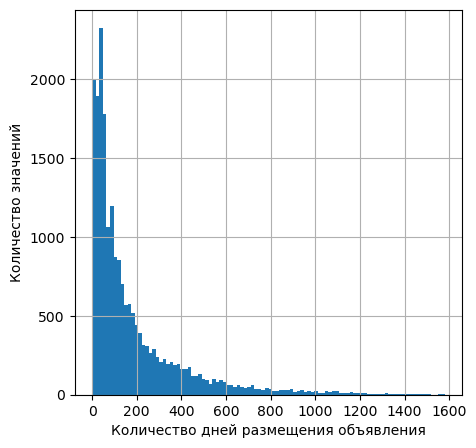

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


In [57]:
data['days_exposition'].hist(bins=100, figsize=(5,5))
plt.xlabel('Количество дней размещения объявления')
plt.ylabel('Количество значений')
plt.show()
print(data['days_exposition'].describe())

Наблюдаем, что данные представляют собой распределение Пуассона, в котором медиана равняется 95 дня, а среднее 180 дней. Такую разницу можно объяснить небольшим количеством объявлений, которые находились на платформе несколько лет. Таким образом, можем считать, что если квартира продается за 3 месяца - то это хороший результат, соответственно все квартиры, которые продаются меньше 3 месяцев можно считать быстрыми продажами, а дольше - медленными.

### Анализ стоимости

Проверим как зависит цена от:
* общей площади
* жилой площади
* площади кухни
* количества комнат
* этажа, на котором расположена квартира (первый, последний, другой)
* даты размещения (день недели, месяц, год).

Для начала построим матрицу корреляции в виде тепловой карты

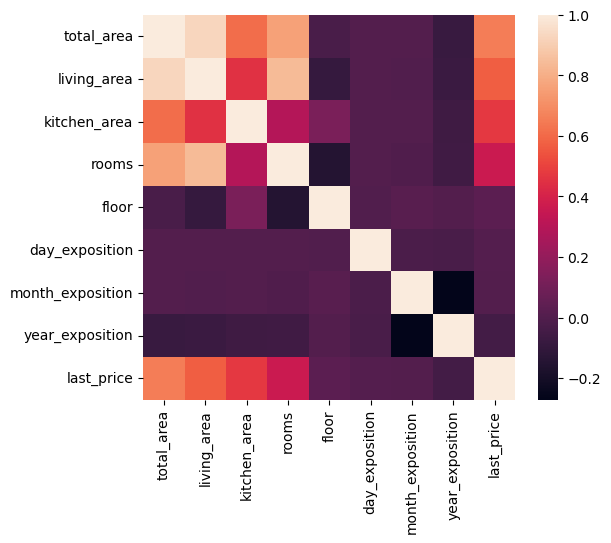

In [58]:
plt.subplots(figsize=(6, 5))
sns.heatmap(data[['total_area', 'living_area', 'kitchen_area',
                  'rooms', 'floor', 'day_exposition',
                  'month_exposition', 'year_exposition', 'last_price']].corr())
plt.show()

Как мы ранее и утверждали, что между общей, жилой, площадью кухни и количеством комнат есть прямая корреляция. Сейчас мы это подтвердили. Заметим, что также есть связь между этими же факторами и ценой за квартиру, что выглядит вполне логичным. Связь между датой публикации объявления, этажом на котором располагается объект продажи с ценой объекта полностью отсутствует.

#### Факторы площади

`total_area` - общая площадь квартиры в квадратных метрах (м²)

`living_area` - жилая площадь в квадратных метрах (м²)

`kitchen_area` - площадь кухни в квадратных метрах (м²)

`rooms` - число комнат

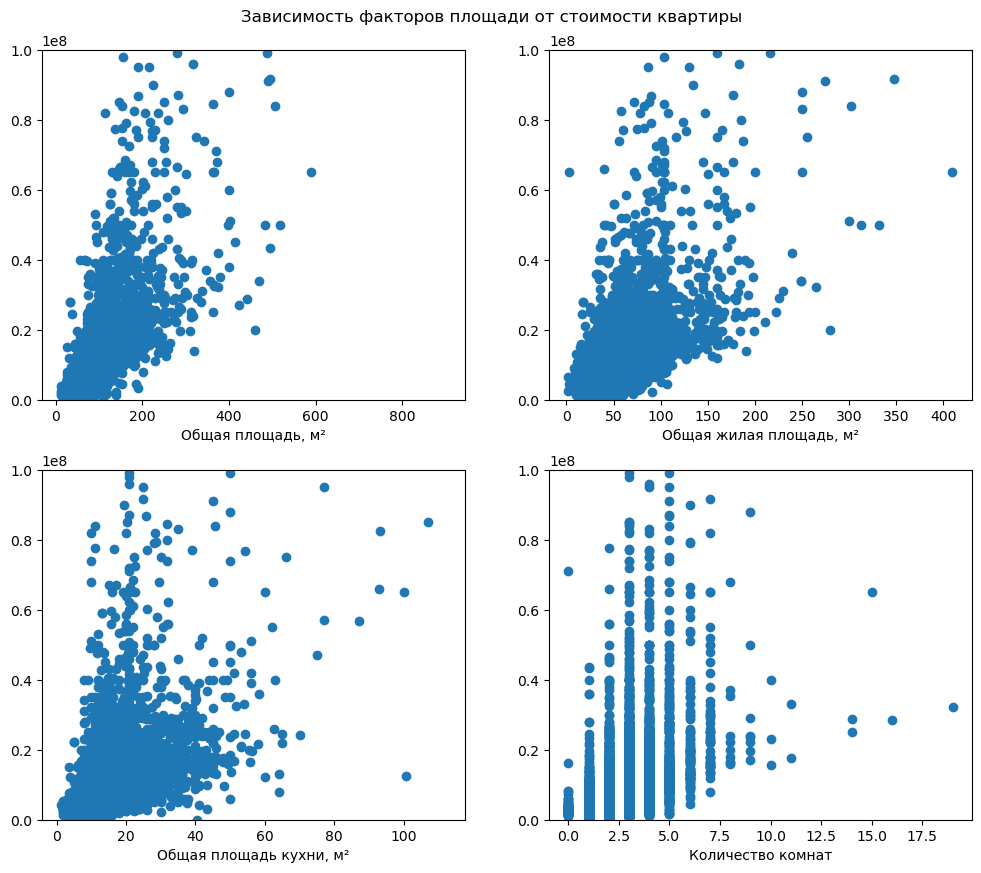

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(data=data, x='total_area', y='last_price')
axes[0, 1].scatter(data=data, x='living_area', y='last_price')
axes[1, 0].scatter(data=data, x='kitchen_area', y='last_price')
axes[1, 1].scatter(data=data, x='rooms', y='last_price')

axes[0, 0].set_ylim(0,100000000)
axes[0, 1].set_ylim(0,100000000)
axes[1, 0].set_ylim(0,100000000)
axes[1, 1].set_ylim(0,100000000)

axes[0, 0].set_xlabel('Общая площадь, м²')
axes[0, 1].set_xlabel('Общая жилая площадь, м²')
axes[1, 0].set_xlabel('Общая площадь кухни, м²')
axes[1, 1].set_xlabel('Количество комнат')

fig.suptitle('Зависимость факторов площади от стоимости квартиры', y=0.92)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

Наибольшая корреляция видна на графики зависимости между фактором общей площади и стоимости квартиры. Максимально логичный вывод: чем больше квартира, чем больше комнат и чем больше кухня, тем дороже она будет стоить.

#### `floor_type` - тип этажа

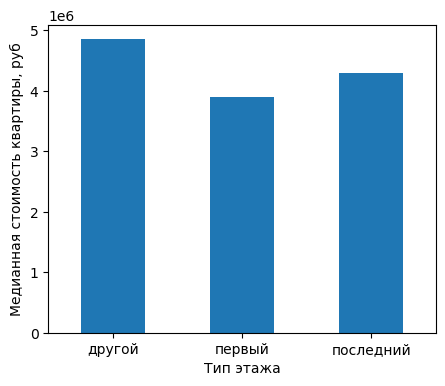

In [60]:
fig, axes = plt.subplots(figsize=(5, 4))
data.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot(kind='bar',
                                                                                 rot=0,
                                                                                 ax=axes,
                                                                                 legend=False)
plt.xlabel('Тип этажа')
plt.ylabel('Медианная стоимость квартиры, руб')
plt.show()

Исходя из данной гистограммы можно сделать вывод, что цена квартиры на первом этаже меньшее, чем на последнем, а на последнем меньше, чем на любом другом кроме первого. 

Цена квартиры на первом этаже может быть дешевле по ряду причин: 
* в них чаще забираются воры
* под окнами бывает шумно
* из подвала могут проникать неприятные запахи. 

Квартиры же на последнем этаже могут быть дешевле по следующим причинам: 
* воры, которые могут забраться в помещение через крышу
* не все пожарные лестницы дотягиваются до крыш высоток
* электромагнитное излучение, которое исходит от электроприборов

На матрице корреляции видно, что прямой связи между днем, месяцем и годом публикации объявления с ценой квартиры нет, однако в пункте 4.1.4 мы уже смотрели как менялась медианная цена за квадратный метр по месяцам изучаемого периода. Выведем тут зависимость именно от стоимости квартиры и убедимся, что графики похожи.

#### Дата размещений объявления

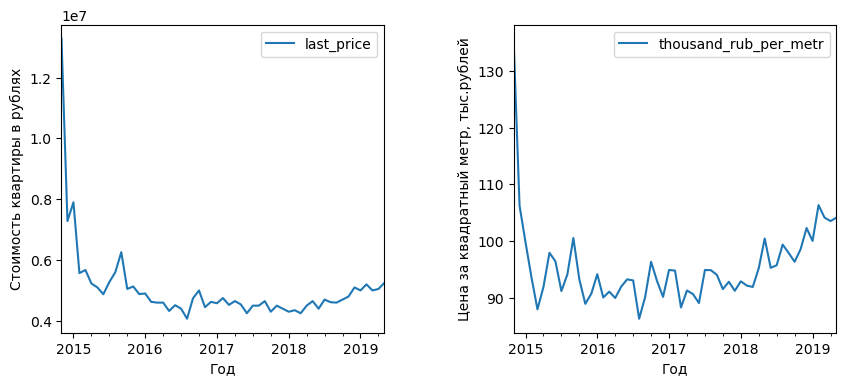

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
data.pivot_table(index='date_month', values='last_price',
                                              aggfunc='median').plot(ax=axes[0])
data.pivot_table(index='date_month', values='thousand_rub_per_metr',
                                              aggfunc='median').plot(ax=axes[1])

axes[0].set_ylabel('Стоимость квартиры в рублях')
axes[1].set_ylabel('Цена за квадратный метр, тыс.рублей')

axes[0].set_xlabel('Год')
axes[1].set_xlabel('Год')

plt.subplots_adjust(wspace=0.4)
plt.show()

График справа, который показывает зависимость цены за квадратный метр от месяца публикации объявления показывает более сильную тенденцию на рост с 2017 года, чем график слева. Можно предположить, что квартиры становились дороже, однако площадь их была та же.

### Анализ цены одного квадратного метра

In [62]:
# выделим топ 10 наиболее популярных мест продаж квартир
top10_locations = data['locality_name_correct'].value_counts().head(10).index

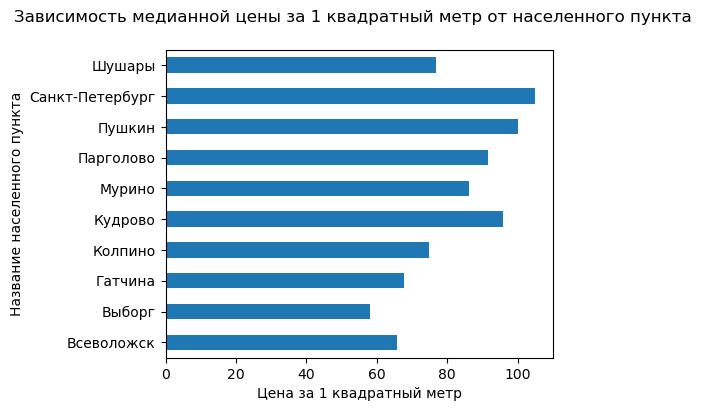

In [63]:
fig, axes = plt.subplots(figsize=(5, 4))
data.query('locality_name_correct in @top10_locations').pivot_table(index='locality_name_correct',
                                                                    values='thousand_rub_per_metr',
                                                                    aggfunc='median').plot(kind='barh',
                                                                                           legend=False,
                                                                                           ax=axes)
fig.suptitle('Зависимость медианной цены за 1 квадратный метр от населенного пункта')
plt.xlabel('Цена за 1 квадратный метр')
plt.ylabel('Название населенного пункта')
plt.show()

Среди 10 населенных пунктов с наибольшим числом объявлений наиболее дорогими являются: Санкт-Петербург, Пушкин и Кудрово. А наиболее дешевый квадратный метр в населенном пункте Выборг.

Выглядит опять же логично: Санкт-Петербург - вторая столица России, а Пушкин и Кудрово находятся недалеко от второй столицы. Выборг же, в свою очередь, находится в относительно неудачном территориальном расположении, поэтому и цена ниже.

### Анализ зависимости цены от расстояния до центра в километрах

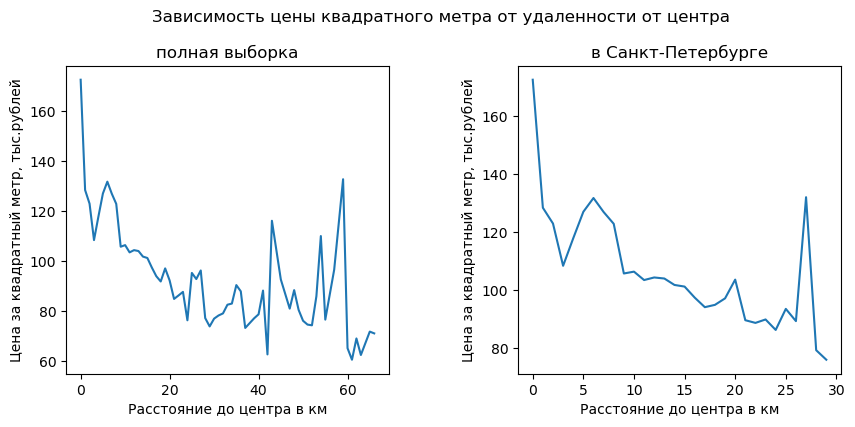

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
data.pivot_table(index='center_km',
                 values='thousand_rub_per_metr',
                 aggfunc='median').plot(ax=axes[0], legend=False)
data.query("locality_name_correct == 'Санкт-Петербург'").pivot_table(index='center_km',
                 values='thousand_rub_per_metr',
                 aggfunc='median').plot(ax=axes[1], legend=False)

axes[0].set_ylabel('Цена за квадратный метр, тыс.рублей')
axes[1].set_ylabel('Цена за квадратный метр, тыс.рублей')

fig.suptitle('Зависимость цены квадратного метра от удаленности от центра', y=1.02)
axes[0].set_title('полная выборка')
axes[1].set_title('в Санкт-Петербурге')

axes[0].set_xlabel('Расстояние до центра в км')
axes[1].set_xlabel('Расстояние до центра в км')

plt.subplots_adjust(wspace=0.4)
plt.show()

На графике слева видно, что в радиусе 40 километров цена за квадратный метр падает при удалении от центра, однако за тем видим резкие пики роста в радиусе от 40 до 60 км. Возможно в этом радиусе находятся элитные поселки, которые и выбиваются из тенденции падения цены при удалении от центра.

Если основываться на выборки объявлений по городу Санкт-Петербург, то видим ту же картину: чем дальше от центра, тем дешевле квадратный метр. Объясняем это тем, что из центра города доехать в любую другую точку в среднем быстрее и инфраструктура в центре сильнее развита, чем в 20 км от него, поэтому и спрос на квартиры в центре выше.

## Общий вывод

В ходе данного исследования был проведен анализ данных рынка недвижимости в городе Санкт-Петербург и Ленинградской области. В первую очередь была произведена предобработка исходного датасета. Конкретно были выполнены следующие шаги:
1. Обработка пропущенных значений
2. Корректировка типов данных
3. Удаление дубликатов
4. Обработка аномальных значений

Этап предобработки данных был необходим для дальнейшего исследования и получения зависимостей различных факторов между собой. По результатам анализа рынка недвижимости Санкт-Петербурга можно сделать вывод о том, что цены на жилье продолжают расти. В течение последних лет наблюдался значительный спрос на квартиры и дома в городе, что привело к увеличению стоимости недвижимости. 

Вместе с тем, следует отметить, что на рынке недвижимости Санкт-Петербурга наблюдается определенное разнообразие и дифференциация цен в зависимости от района и класса жилья. Так, в центральных районах города цены на жилье значительно выше, чем в отдаленных районах.

Однако, несмотря на высокую стоимость жилья в Санкт-Петербурге, спрос на недвижимость в этом регионе не уменьшается, что свидетельствует о стабильности и перспективах рынка. В целом, рынок недвижимости Санкт-Петербурга остается привлекательным для инвесторов и покупателей недвижимости.